# Midplane Section Analysis
Code to analyze the result of `midplane_section.py`

## Imports

In [68]:
# %% Imports
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.integrate
import scipy.interpolate

## Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

import pyvista as pv

from tqdm import tqdm
%matplotlib qt

## Utility libraries
from netCDF4 import Dataset
import glob

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, GaussHermiteFunction
from c1lgkt.fields.field_interpolators import compute_balloon_interpolation
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# %% Load files and perform setup

eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')

xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, **geom_files)

uph = np.load('./outputs/phase_vel.npz')['u_lstsq']

# Set up zonal interpolation function
tind = 401
zpot = xgcdata['pot00'][tind,:]
zpot_psi = xgcdata['psi00'][:]
interp_zpot = scipy.interpolate.CubicSpline(zpot_psi, zpot, extrapolate=True)
zonalFields = XgcZonalFieldHandler(eq, xgcdata, 401)

# Set up ballooning mode interpolator
fit_results = np.load('./outputs/fit_results.npz', allow_pickle=True)
params_g, params_gh = fit_results['params_g'], fit_results['params_gh']

# Set up the interpolator
mode = GaussHermiteFunction(params_g[:4], params_gh)
interp_balloon = [(39, mode)]

ballFields = GaussHermiteFieldHandler(geom, interp_zpot, interp_balloon)

tind0 = 401 #424, 386

omega_frame = -uph[tind0,196]*geom.q_surf[196]*1e-3
rotating_frame = particle_motion.RotatingFrameInfo(0, omega_frame, tind0)
t0 = rotating_frame.t0

In [ ]:
# %% Load data and compute Poincare sections

filelabel = 'midplane_deut_test_r50'
output_dir = 'D:/Documents/IFS/hmode_jet/outputs/'

paths = glob.glob(output_dir+'sections/{}_[0-9][0-9][0-9][0-9][0-9].npz'.format(filelabel))

num_saves = len(paths)
print('num_saves: {}'.format(num_saves))
ncheckpoint = 800

t = np.empty(num_saves*ncheckpoint)
y = None
dy = None


for kc in range(num_saves):
    with np.load(output_dir + 'sections/{}_{:05d}.npz'.format(filelabel, kc)) as data:
        t[kc*ncheckpoint:(kc+1)*ncheckpoint] = data['t']
        if kc == 0:
            y = np.empty((data['y'].shape[0], len(t)))
            dy = np.empty((data['y'].shape[0], len(t)))
            
        y[:,kc*ncheckpoint:(kc+1)*ncheckpoint] = data['y']
        dy[:,kc*ncheckpoint:(kc+1)*ncheckpoint] = data['dy']

nump = y.shape[0]//5

# Compute Poincare section
ppunc, npunc = particle_tools.compute_midplane_punctures(t, y, geom)
ppunc2, npunc2 = particle_tools.compute_toroidal_punctures(t, y, rotating_frame, period=(2*np.pi/39))


num_saves: 35


## Analysis

In [92]:
# %% Plot trajectories in the (R,Z) plane atop the ballooning mode

plt.figure()

ax = plt.subplot(111)

eq.plot_magnetic_geometry(ax)
for k in [0]:
    ax.plot(y[k + 0*nump,:], y[k + 2*nump,:], marker='.')

rplot, zplot = np.linspace(2.15, 2.26, 256), np.linspace(-0.2, 0.2, 1024)
rgrid, zgrid = np.meshgrid(rplot, zplot)
varphigrid = np.zeros(rgrid.shape)

rflat, zflat, varphiflat = rgrid.flatten(), zgrid.flatten(), varphigrid.flatten()

psi_ev, ff_ev = eq.compute_psi_and_ff(rflat, zflat)

phi = compute_balloon_interpolation(
    0.0, rflat, zflat, varphiflat, psi_ev, eq, geom, [interp_balloon], gradient=False)

phigrid = phi.reshape(rgrid.shape)

plt.pcolormesh(rplot, zplot, phigrid, cmap='viridis')

plt.xlabel('R')
plt.ylabel('Z')

Text(0, 0.5, 'Z')

In [58]:
# %% Plot trajectories in phi, theta plane

def centerize(z):
    return np.mod(z+np.pi,2*np.pi)-np.pi

plt.figure()

k = 1

theta = geom.compute_theta(y[k + 0*nump], y[k + 2*nump])
psi = eq.interp_psi.ev(y[k + 0*nump], y[k + 2*nump])
#plt.scatter(np.mod(y[k + 1*nump],2*np.pi), centerize(theta), c=psi, s=9*(72/100.0)**2)

plt.scatter(psi / eq.psix, theta, s=4*(72/100.0)**2, lw=0, c=t)

plt.xlabel('psi_n')
plt.ylabel('theta')

Text(0, 0.5, 'theta')

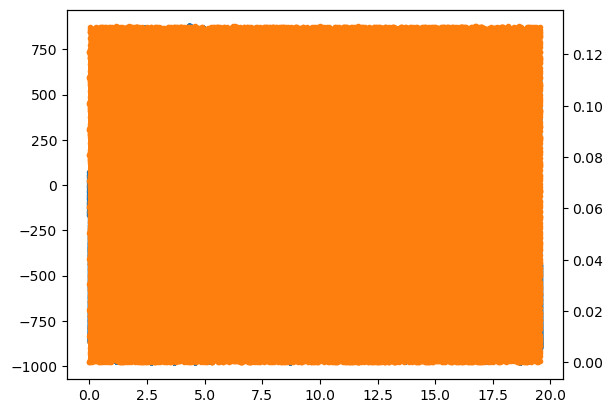

In [7]:
# %% Plot trajectories vs. time

k = 0

plt.figure()
plt.plot(t, dy[k + 3*nump], marker='.')
plt.twinx()
plt.plot(t, np.mod(y[k + 1*nump],2*np.pi/48), marker='.', c='tab:orange')

In [94]:
# %% Plot the outer midplane section

fig, axs = plt.subplots(2,1,sharex='all',sharey='all')

ravgs = np.empty(nump)

for k in range(nump):
    ravgs[k] = np.average(np.concatenate((ppunc[k][1][0,:], npunc[k][1][0,:])))

    #cplot = 'tab:blue' if ravgs[k] > 2.2259 else 'tab:orange'
    #cplot = 'tab:blue'

    axs[0].scatter(np.mod(ppunc[k][1][1,:] - omega_frame * (ppunc[k][0] - t0),2*np.pi/3), ppunc[k][1][0,:], s=9*(72/100.0)**2, lw=0)
    axs[1].scatter(np.mod(npunc[k][1][1,:] - omega_frame * (npunc[k][0] - t0),2*np.pi/3), npunc[k][1][0,:], s=9*(72/100.0)**2, lw=0)

    #axs[0].plot(ppunc[k][1][1,:] - omega_frame * (ppunc[k][0] - t0), ppunc[k][1][0,:], marker='.')
    #axs[1].plot(npunc[k][1][1,:] - omega_frame * (npunc[k][0] - t0), npunc[k][1][0,:], marker='.')

#axs[0].axhline(2.2259, c='k')
#axs[1].axhline(2.2259, c='k')

#plt.suptitle('Trapped electron Poincare section')

axs[1].set_xlabel(R'Toroidal angle $\varphi$')
#axs[0].set_ylabel(R'Major radius $R$')
axs[0].set_ylabel(R'Major radius $R$')

plt.tight_layout()

In [95]:

# %% Plot the poloidal cross-section section

fig, axs = plt.subplots(1,2,sharex='all',sharey='all')

ravgs = np.empty(nump)

eq.plot_magnetic_geometry(axs[0])
eq.plot_magnetic_geometry(axs[1])

plt.pcolormesh(rplot, zplot, phigrid, cmap='viridis')

for k in range(nump):
    #ravgs[k] = np.average(np.concatenate((ppunc[k][1][0,:], npunc[k][1][0,:])))

    #cplot = 'tab:blue' if ravgs[k] > 2.2259 else 'tab:orange'
    #cplot = 'tab:blue'

    axs[0].scatter(ppunc2[k][1][0,:], ppunc2[k][1][2,:], s=4*(72/100.0)**2, lw=0)
    axs[1].scatter(npunc2[k][1][0,:], npunc2[k][1][2,:], s=4*(72/100.0)**2, lw=0)




In [96]:

# %% Poloidal cross-section v2


fig, axs = plt.subplots(2,1,sharex='all')

ravgs = np.empty(nump)

maxrot = -np.inf
minrot = np.inf

for k in range(nump):
    #ravgs[k] = np.average(np.concatenate((ppunc[k][1][0,:], npunc[k][1][0,:])))

    
    #cplot = 'tab:blue'

    thetap = geom.compute_theta(ppunc2[k][1][0,:], ppunc2[k][1][2,:])
    psip = eq.interp_psi.ev(ppunc2[k][1][0,:], ppunc2[k][1][2,:])
    thetan = geom.compute_theta(npunc2[k][1][0,:], npunc2[k][1][2,:])
    psin = eq.interp_psi.ev(npunc2[k][1][0,:], npunc2[k][1][2,:])

    #axs[0].scatter(thetap, ppunc2[k][1][3,:], s=1*(72/100.0)**2, lw=0)
    #axs[1].scatter(thetan, npunc2[k][1][3,:], s=1*(72/100.0)**2, lw=0)

    #cplotp = 'tab:blue' if np.average(psip) > geom.psi_surf[200] else 'tab:orange'
    #cplotn = 'tab:blue' if np.average(psin) > geom.psi_surf[200] else 'tab:orange'

    # eq.interp_router(psip/eq.psix)

    if k%2 == 1:
        axs[0].scatter(thetap, psip, s=4*(72/100.0)**2, lw=0)
    else:
        axs[1].scatter(thetan, psin, s=4*(72/100.0)**2, lw=0)

axs[1].set_xlabel(R'Poloidal angle $\theta$')
axs[0].set_ylabel(R'Mapped outboard midplane $R$')

plt.suptitle(R'Passing ion Poincare section')

Text(0.5, 0.98, 'Passing ion Poincare section')

In [42]:
np.diff(ppunc[0][0])

array([0.18188706, 0.17108981, 0.16852668, 0.16297331, 0.1640484 ,
       0.15815972, 0.16384656, 0.17351434, 0.18004782, 0.18259915,
       0.18545698, 0.18202316, 0.18003062, 0.17330836, 0.16613062,
       0.15882731, 0.16314154, 0.17270072, 0.17980953, 0.1812788 ,
       0.18798942, 0.19280634, 0.19783048, 0.19497158, 0.18910652,
       0.18460915, 0.18047828, 0.17534475, 0.1829272 , 0.18870703,
       0.19546652, 0.1997632 , 0.20127618, 0.20223439, 0.20101312,
       0.19908622, 0.19866166, 0.20003166, 0.19928455, 0.19485718,
       0.19850974, 0.19861613, 0.19523173, 0.19446546, 0.19721303,
       0.20011403, 0.20141217, 0.19938673, 0.19874402, 0.2001918 ,
       0.19978974, 0.19525821, 0.19084035, 0.19657404, 0.19281112,
       0.18669894, 0.18920436, 0.18384889, 0.17344743, 0.16382877,
       0.15838583, 0.16147427, 0.15771097, 0.16343431, 0.17117778,
       0.16266494, 0.16617648, 0.17647703, 0.18406891, 0.1891061 ,
       0.18713437, 0.19215254, 0.18359155, 0.17469789, 0.17134

In [28]:
t

array([0.00000000e+00, 2.46962500e-04, 4.93925000e-04, ...,
       1.95586891e+01, 1.95589361e+01, 1.95591830e+01])

In [33]:
xgcdata['t'][:]*1e3

masked_array(data=[0.0039514, 0.0079028, 0.0118542, 0.0158056, 0.019757 ,
                   0.0237084, 0.0276598, 0.0316112, 0.0355626, 0.039514 ,
                   0.0434654, 0.0474168, 0.0513682, 0.0553196, 0.059271 ,
                   0.0632224, 0.0671738, 0.0711252, 0.0750766, 0.079028 ,
                   0.0829794, 0.0869308, 0.0908822, 0.0948336, 0.098785 ,
                   0.1027364, 0.1066878, 0.1106392, 0.1145906, 0.118542 ,
                   0.1224934, 0.1264448, 0.1303962, 0.1343476, 0.138299 ,
                   0.1422504, 0.1462018, 0.1501532, 0.1541046, 0.158056 ,
                   0.1620074, 0.1659588, 0.1699102, 0.1738616, 0.177813 ,
                   0.1817644, 0.1857158, 0.1896672, 0.1936186, 0.19757  ,
                   0.2015214, 0.2054728, 0.2094242, 0.2133756, 0.217327 ,
                   0.2212784, 0.2252298, 0.2291812, 0.2331326, 0.237084 ,
                   0.2410354, 0.2449868, 0.2489382, 0.2528896, 0.256841 ,
                   0.2607924, 0.264743